# Weeks 13-14

## Natural Language Processing
***

Read in some packages.

In [1]:
# Import pandas to read in data
import numpy as np
import pandas as pd

# Import models and evaluation functions
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn import cross_validation

# Import vectorizers to turn text into numeric
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import plotting
import matplotlib.pylab as plt
%matplotlib inline

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Basic Feature Engineering
We have examined two ways of dealing with categorical (i.e. text based) data: binarizing/dummy variables and numerical scaling. 

See the following examples for implementation in sklearn to start:

In [2]:
data = pd.read_csv("data/categorical.csv")

In [3]:
data

,Minutes,Gender,Marital,Satisfaction,Churn
0,100,Male,Single,Low,0
1,220,Female,Married,Very Low,0
2,500,Female,Divorced,High,1
3,335,Male,Single,Neutral,0
4,450,Male,Married,Very High,1


### Binarizing
Get a list of features you want to binarize, go through each feature and create new features for each level.

In [4]:
features_to_binarize = ["Gender", "Marital"]

# Go through each feature
for feature in features_to_binarize:
    # Go through each level in this feature (except the last one!)
    for level in data[feature].unique()[0:-1]:
        # Create new feature for this level
        data[feature + "_" + level] = pd.Series(data[feature] == level, dtype=int)
    # Drop original feature
    data = data.drop([feature], 1)

In [5]:
data

,Minutes,Satisfaction,Churn,Gender_Male,Marital_Single,Marital_Married
0,100,Low,0,1,1,0
1,220,Very Low,0,0,0,1
2,500,High,1,0,0,0
3,335,Neutral,0,1,1,0
4,450,Very High,1,1,0,1


### Numeric scaling
We can also replace text levels with some numeric mapping we create

In [6]:
data['Satisfaction'] = data['Satisfaction'].replace(['Very Low', 'Low', 'Neutral', 'High', 'Very High'], 
                                                    [-2, -1, 0, 1, 2])

In [7]:
data

,Minutes,Satisfaction,Churn,Gender_Male,Marital_Single,Marital_Married
0,100,-1,0,1,1,0
1,220,-2,0,0,0,1
2,500,1,1,0,0,0
3,335,0,0,1,1,0
4,450,2,1,1,0,1


## Text classification
We are going to look at some Amazon reviews and classify them into positive or negative.

### Data
The file `data/books.csv` contains 2,000 Amazon book reviews. The data set contains two features: the first column (contained in quotes) is the review text. The second column is a binary label indicating if the review is positive or negative.

Let's take a quick look at the file.

In [8]:
!head -3 data/books.csv

'head' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


Let's read the data into a pandas data frame. You'll notice two new attributed in `pd.read_csv()` that we've never seen before. The first, `quotechar` is tell us what is being used to "encapsulate" the text fields. Since our review text is surrounding by double quotes, we let pandas know. We use a `\` since the quote is also used to surround the quote. This backslash is known as an escape character. We also let pandas now this.

In [9]:
data = pd.read_csv("data/books.csv", quotechar="\"", escapechar="\\")

In [10]:
data.head()

,review_text,positive
0,THis book was horrible. If it was possible to...,0
1,I like to use the Amazon reviews when purchasi...,0
2,THis book was horrible. If it was possible to...,0
3,"I'm not sure who's writing these reviews, but ...",0
4,I picked up the first book in this series (The...,0


### Text as a set of features
Going from text to numeric data is very easy. Let's take a look at how we can do this. We'll start by separating out our X and Y data.

In [11]:
X_text = data['review_text']
Y = data['positive']

In [12]:
# look at the first few lines of X_text
X_text.head()

0    THis book was horrible.  If it was possible to...
1    I like to use the Amazon reviews when purchasi...
2    THis book was horrible.  If it was possible to...
3    I'm not sure who's writing these reviews, but ...
4    I picked up the first book in this series (The...
Name: review_text, dtype: object

Do the same for Y

In [13]:
# your code here
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: positive, dtype: int64

Next, we will turn `X_text` into just `X` -- a numeric representation that we can use in our algorithms or for queries...

Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors. 

The result of the following is a matrix with each row a file and each column a word. The matrix is sparse because most words only appear a few times. The values are 1 if a word appears in a document and 1 otherwise.

In [14]:
# Create a vectorizer that will track text as binary features
binary_vectorizer = CountVectorizer(binary=True)

# Let the vectorizer learn what tokens exist in the text data
binary_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = binary_vectorizer.transform(X_text)

In [15]:
# Dimensions of X:
X.shape

(2000, 22743)

There are 2000 documents (each row) and 22,743 words/tokens.

Can look at some of the words by querying the binary vectorizer:

In [16]:
# List of the 20 features (words) in column 10,000
features = binary_vectorizer.get_feature_names()
features[10000:10020]

['hygi',
 'hygience',
 'hygiene',
 'hyojin',
 'hype',
 'hyped',
 'hyper',
 'hyperbole',
 'hyperpat',
 'hyperpussiance',
 'hyperspace',
 'hypnosis',
 'hypnotic',
 'hypnotism',
 'hypnotizing',
 'hypocrisy',
 'hypocrite',
 'hypocritical',
 'hypocritically',
 'hypoglycemia']

Spend some time to look at the binary vectoriser.

Examine the structure of X. Look at some the rows and columns values.

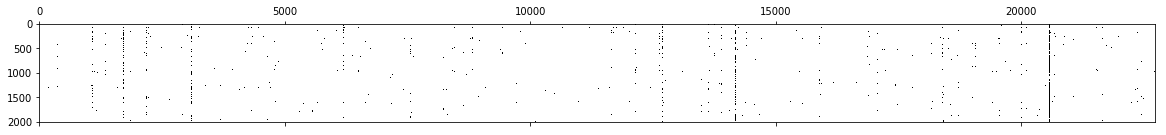

In [17]:
# see the density of 0s and 1s in X
import scipy.sparse as sps
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.spy(X.toarray())
plt.show()

Look at the sparse matrix above. Notice how some columns are quite dark (i.e. the words appear in almost every file). 

What are the 5 most common words?

In [18]:
# your code here
import numpy as np
cnt = np.sum(X.toarray(),axis = 0)
sort_cnt = sorted(cnt,reverse=True)
index = []
for max_num in sort_cnt[:5]:
    for i in range(len(cnt)):
        num = cnt[i]
        if num == max_num:
            if i not in index:
                index.append(i)
common_words=[]
for j in index:
    common_words.append(features[j])
print(common_words)

['the', 'and', 'to', 'of', 'this']


Your answer here

Write a function that takes the sparse matrix X, and gets the feature list from the vectoriser, and a document index (1 - 2000) and returns a list of the words in the file that corresponds to the index (the list should be obtained from the sparse matrix / bag of words representation NOT from the original data file). 

In [19]:
# complete the function 
# returns vector of words / features
def getWords(bag_of_words, file_index_row, features_list):
    row_of_words = bag_of_words.toarray()[0]
    feature_index = []
    words_list = []
    for i in range(len(row_of_words)):
        if row_of_words[i] == 1:
            feature_index.append(i)          
    for j in feature_index:
        words_list.append(features_list[j])
    return words_list

getWords(X, 1, features)


['13',
 '33',
 'about',
 'after',
 'am',
 'an',
 'and',
 'avid',
 'back',
 'better',
 'book',
 'boy',
 'copy',
 'could',
 'don',
 'entire',
 'fire',
 'for',
 'friend',
 'from',
 'got',
 'gotten',
 'had',
 'half',
 'have',
 'headache',
 'horrible',
 'if',
 'in',
 'it',
 'less',
 'life',
 'lit',
 'lower',
 'man',
 'mom',
 'money',
 'my',
 'of',
 'old',
 'on',
 'one',
 'part',
 'picked',
 'possible',
 'purposes',
 'rate',
 'read',
 'reader',
 'reading',
 'relationship',
 'so',
 'spent',
 'star',
 'suffering',
 'than',
 'the',
 'then',
 'this',
 'time',
 'to',
 'up',
 'use',
 'was',
 'waste',
 'wasted',
 'wish',
 'with',
 'world',
 'would',
 'year',
 'your']

### Modeling
We have a 22743 features, let's use them in some different models.

In [20]:
# Create a model
logistic_regression = LogisticRegression()

# Use this model and our data to get 5-fold cross validation accuracy
acc = cross_validation.cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average accuracy rounded to three decimal points
print ("Mean accuracy of our classifier is " + str(round(np.mean(acc), 3)) )

Mean accuracy of our classifier is 0.768


Use the above classifier to classify a new example (new review below):

In [21]:
new_review = ['really bad book']
# your code here ...
X_text = data['review_text']
Y = data['positive']
X_text_a = X_text.values
X_text_a = np.append(X_text_a,new_review)

binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_text_a)
X = binary_vectorizer.transform(X_text_a)

logistic_regression.fit(X[:-1],Y)
result = logistic_regression.predict(X[-1])
print('New review is predicted to be %s'%result)


New review is predicted to be [0]


Let's try using full counts instead of a binary representation (i.e. each time a word appears use the raw count value). 

In [22]:
# Create a vectorizer that will track text as binary features
count_vectorizer = CountVectorizer()

# Let the vectorizer learn what tokens exist in the text data
count_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = count_vectorizer.transform(X_text)

# Create a model
logistic_regression = LogisticRegression()

# Use this model and our data to get 5-fold cross validation accuracy
acc = cross_validation.cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average AUC rounded to three decimal points
print( "Accuracy for our classifier is " + str(round(np.mean(acc), 3)) )

Accuracy for our classifier is 0.786


Now try using TF-IDF:

In [23]:
# Create a vectorizer that will track text as binary features
tfidf_vectorizer = TfidfVectorizer()

# Let the vectorizer learn what tokens exist in the text data
tfidf_vectorizer.fit(X_text)

# Turn these tokens into a numeric matrix
X = tfidf_vectorizer.transform(X_text)

# Create a model
logistic_regression = LogisticRegression()

# Use this model and our data to get 5-fold cross validation AUCs
acc = cross_validation.cross_val_score(logistic_regression, X, Y, scoring="accuracy", cv=5)

# Print out the average AUC rounded to three decimal points
print( "Accuracy for our classifier is " + str(round(np.mean(acc), 3)) )

Accuracy for our classifier is 0.784


Use the tfidf classifier to classify some online book reviews from here: https://www.amazon.com/

Hint: You can copy and paste a review from the online site into a multiline string literal with 3 quotes: 
```
"""
copied and pasted
multiline
string...
"""
```

In [24]:
# your code here
# Book reviews from 'Educated: A Memoir'

new_reviews = ["""In the interest of full disclosure, I'm the Drew from this book, and although Tara and I are no longer together I’ve met all of the key figures in this book on many occasions. Although I don’t have as intimate a knowledge of growing up in the Westover family as a sibling would, I observed first hand everything Tara describes in the third part of the book and heard many stories about earlier events, not just from Tara, but from siblings, cousins, and her parents themselves. I find the claims of factual inaccuracy that have come up among these reviews to be strange for two reasons. First, in a post-James Frey (“A Million Little Pieces”) world, publishers are incredibly careful with memoirs and “Educated” was extensively fact checked before publication. Second, no one claiming factual inaccuracy can do so with any precision. While every Westover sibling, as well as their neighbors and friends, will have different perspectives and different memories, it is very difficult to dispute the core facts of this book. “Educated” is about abuse, and the way in which both abusers and their enablers distort reality for the victims. It’s about the importance of gaining your own understanding of the world so you’re not dependent on the narratives imposed on you by others. I’ve heard Tara’s parents attack schools and universities, doctors and modern medicine, but more importantly, I’ve seen her parents work tirelessly to create a world where Shawn’s abuse was minimized or denied outright. I’ve seen them try to create a world where Tara was insane or possessed in order to protect a violent and unstable brother. I was with her in Cambridge when Shawn was calling with death threats, then saw her mother completely trivialize the experience. For Tara’s parents, allegiance to the family is paramount, and allegiance to the family requires you to accept her father’s view of the world, where violence is acceptable and asking for change is a crime.""",
          """This is an absolutely terrible story, depressing to the end. However, it is compelling, to the point that I stayed up late to finish it. I really can't say whether I would recommend this book or not. At some point I hated every single person in it, including, at times, Tara. The cycle of abuse and ignorance is just so frustrating. Tara's pathological resistance to any sort of help or kindness is somewhat understandable, but still made me want to scream! Reading the book almost felt abusive in a way, although certainly not on the level of abuse inflicted by Shawn or her parents.

The writing quality is all over the place; some parts are masterful and others are creaky and distracting. Tara describes things as "crisp" at an exponential rate. By the last few chapters, everything is "crisp," from bed linens to entire towns. I'm fascinated that this got past her editors. It's such an ugly word to begin with, and then to be hit with it repeatedly, I just don't see how no one noticed (or worse, noticed and decided to keep them all!).

There are major conceptual inconsistencies in this work. Some parts of Tara's story are described in nearly obsessive detail, while pivotal moments are glossed over. She spends pages and pages on her "whore" complex, terrified to even hold a boy's hand, and then the next thing we hear, she's shacking up with her boyfriend all over Europe and the Middle East, without the slightest acknowledgement of what a huge turnabout this is. She ruminates at length over her amateur (though probably correct) diagnosis of her father as bipolar, but barely touches on her own mental health crisis, just describing it as "falling apart" and binge-watching Buffy the Vampire Slayer. If we're going to make armchair diagnoses, I'm calling PTSD for Tara at the very least, and probably some Bipolar II or GAD as well. While in general, people don't owe the public an explanation of their mental state, if you're going to write a very raw and very specific memoir, you can't just skip that part and expect no one to notice.

There's also a strange distance in her relationships with anyone who *didn't* abuse her. I suppose this is typical of an abuse survivor, but it's unsettling nonetheless. Tara seems unable to explicitly acknowledge the kindness and sensitivity with which so many "outside" people treated her. They're there, she describes their actions, but there's a void where I would expect to read gratefulness or even fondness. In particular, the dance teacher who discreetly accommodated her need for a modest costume, the ward bishop who tried so hard and so many times to help her, and the roommate who quietly taught Tara how to act normal -- they're all mentioned, and I suppose that is meant to be thanks enough, but it almost seems like she resents their generosity. I'm also confused about her omission of Luke in the credits. What did he do wrong? She seemed to be on good terms with him when is last briefly mentioned, but apparently only siblings with PhDs make it to the Acknowledgements.

This is a powerful and affecting story; it really couldn't *not* be. However, I wonder what it would be like if Tara had waited another 10-20 years to write it. She's no doubt an intelligent (and, yes, educated) woman, but there's a dearth of maturity and sensitivity in this story that is not surprising, given what her family put her through, yet it taints the story all the same.

I'm very torn on this book. I did not find it inspiring and will not read it again, but I'm not going to say it's bad or that no one should read it all. It's just grueling and stressful. Maybe don't read it if you're already having a tough time in your own life. I finished it a week ago and took some time to let it settle in my mind before writing a review, but I'm still on the fence. Maybe I should've waited another 10-20 years to review it. """,
          """In the interest of full disclosure, I'm the Drew from this book, and although Tara and I are no longer together I’ve met all of the key figures in this book on many occasions. Although I don’t have as intimate a knowledge of growing up in the Westover family as a sibling would, I observed first hand everything Tara describes in the third part of the book and heard many stories about earlier events, not just from Tara, but from siblings, cousins, and her parents themselves. I find the claims of factual inaccuracy that have come up among these reviews to be strange for two reasons. First, in a post-James Frey (“A Million Little Pieces”) world, publishers are incredibly careful with memoirs and “Educated” was extensively fact checked before publication. Second, no one claiming factual inaccuracy can do so with any precision. While every Westover sibling, as well as their neighbors and friends, will have different perspectives and different memories, it is very difficult to dispute the core facts of this book. “Educated” is about abuse, and the way in which both abusers and their enablers distort reality for the victims. It’s about the importance of gaining your own understanding of the world so you’re not dependent on the narratives imposed on you by others. I’ve heard Tara’s parents attack schools and universities, doctors and modern medicine, but more importantly, I’ve seen her parents work tirelessly to create a world where Shawn’s abuse was minimized or denied outright. I’ve seen them try to create a world where Tara was insane or possessed in order to protect a violent and unstable brother. I was with her in Cambridge when Shawn was calling with death threats, then saw her mother completely trivialize the experience. For Tara’s parents, allegiance to the family is paramount, and allegiance to the family requires you to accept her father’s view of the world, where violence is acceptable and asking for change is a crime. """,
          """ I was enthralled and moved by this powerful memoir. The author grew up in a survivalist family in Idaho, the youngest child. She was not homeschooled---instead, she simply didn't go to school at all, due to her father's mistrust of public schools. Her family didn't believe in modern medicine. Instead, her mother was an herbalist and midwife. Her father owned a junkyard. Her childhood is affected over and over by serious injuries of family members, injuries which are not treated.

As Tara gets into her preteen and teen years, one older brother in particular starts tormenting her, and the tormenting rises to the level of hugely severe abuse. In part in response to this, she decides to go to college, and by pretty much sheer force of will, does well enough on the ACT to get into Brigham Young University. From there, she starts a storied college career and eventually gets a doctorate from Cambridge. However, each time she is drawn back to the her family, her brother's abuse continues, and the family denial turns more and more severe. The memoir becomes a story of her internal struggle---to believe her own version of her life and to have the strength to break away from her past.

I've struggled with some issues of my own in remembering the past differently than others, and I well know the feeling that the author has over and over. One line, "reality becomes fluid", hit me very hard. When you know something happened a certain way, but others can't accept that reality and attempt to change the past by denying it---Tara Westover is able to write about this so powerfully I was crying at points.

I hope this book gets wide readership. It's an amazing glimpse into a way of life that most of us will never know, and an inspiring story of one woman's ability to change her future.""",
          """I loved this book because it mirrors my own life so much and was so validating. My mother has borderline personality disorder, I ran away from home to get a medical degree never believing I could, and still I am often shocked with how my family makes me out to be a terrible person when I get along with the rest of the world besides them so well. My whole life I had wondered what was wrong with me, until I moved away and realized it was my family, not me, and I grew up in severe dysfunction. Ditching narrow minded religion (of the Catholic variety) was the best thing I ever did for myself. I thoroughly enjoyed this because I have lived a similar story and it is always nice to hear you are not alone. Fantastic read. Thank you for writing this Dr. Westover. It was so nice to hear it’s not just me.""",
         
          """I found it very hard to believe . Many of the harrowing experiences would drive a person to report abuse or anyone who escaped that family would be be in a psychiatric ward rather than Cambridge. But hey, it worked for her. I find memoirs to be a lot of fiction. I hope Shawn get help.""",
          """I did not like the story. It was totally depressing from start to finish. I also found it hard to believe and I did not like the writing style.""",
          """Unfortunately thousands of adults (mainly women) could write autobiographies about living with enabling mothers. controlling fathers, and being enablers themselves. Maybe with less medical emergencies thrown in!

There was no insight into why women live this way. Why women with a chance to leave abusive destructive relationships, families, stay. Why women, (her mother), live with, stay with and enable abusive, mentally ill, men. More importantly how to change, how to leave.

The book begins with Tara as a young child so she knows no other way. However she is, I believe, around 28 years old with a PhD in history from Cambridge by the end of the book. Absolutely no insight as to why, even as an adult, she continually returns home and tolerates, allows, family, young children, relatives, to be harmed living in this horrible family dynamic.""",
          """The whole book dragged along , I forced myself to finish but disliked the energy that was no where. The whole tone was monotone""",
          """I have no doubt Tara Westover had a terrible childhood and terrible parents, but like the author of The Glass Castle, there are just too many unbelievable medical emergencies. A car accident where the whole family goes over a cliff without wearing seatbelts and no one dies seemed incredible. The mother is supposedly brain damaged after the accident, but there's no diagnosis from a medical professional to confirm that. But the brother catching on fire to the point that his skin is burned off down to muscle and sinew, and he recovers from that injury without attention from real medical professionals, well, that's just too much for me to stomach or frankly believe. That something terrible happened to her brother, I believe. That her horrible parents caused something terrible to happen to her brother, I believe. But that he suffered what she describes as third-degree burns, sought no medical attention, and actually recovered, no, I don't believe that. I'm sorry this memoir wasn't believable for me, so it wasn't instructive. I returned it to Audible. But I have to say, Julia Whelan, the narrator was great.""",
          """Boring and tedious""",
          """I read this book as the May selection for the PBS/NYT "Now Read This" book club. I applaud Dr. Westover's courage and determination to live her life in her own terms, and those who have helped encourage and support her alone by the way. I am furious with her family, especially her mother. I support the constitutional right to religious freedom, but I do take exception when that belief infringes on the rights of others (such as the Westover children's right to an (actual) education) or harms them in any way (such as the physical, mental and emotional abuse the kids suffered within the family). There is an argument that can be made that many of the family's issues stem from illnesses and lingering effects of injuries that were never treated or healed properly due to their disbelief in modern medicine, but I can't believe Dr. Whatever's mother could be such a commanding presence as a midwife, and be done deeply affected by the lives of strangers she brought into the world, and yet be sidelined so easily when it came to her own daughter's wellbeing. I don't understand how a woman can get more lathered up about funeral thank you cards than the fact that her daughter was being abused.""",
          """After reading just a couple chapters of Educated, my first thought was that it is similar to Glass Castle, a book I loved. Upon reading further, I realized there were some similarities, but Educated is actually quite different.

I found this book so interesting that at times, it read like a novel. There were also a few times where I thought the book dragged and the author repeated herself.

I'm glad Tara was able to see there was a whole other world out there than the one she was living. She seemed to recognize from an early age that most families didn't live like hers. As a young child, she really received very little teaching--very little other than how to help her dad with his scrapping business and how to help her mother as a midwife and and homeopathic specialist. It is clear she has innate intelligence, as she is able to teach herself what was needed to pass the ACT with a score high enough to be accepted to BYU. Upon attending BYU, it was clear she knew very little about how to live as a traditional American. She had never heard of the holocaust. She didn't know how to dress to attend lectures.

I would have liked Tara to have included a little more information about her relationship with the men in her life outside of the family. The only real experience with men prior to college were with one of her employers and her repressive father and abusive brother. I think it would be interesting if she had described how these relationships affected those with the men she dated throughout her college experience, but most of this is glossed over.

All in all though, this is an interesting and well-written story. I would recommend it for all fans of The Glass Castle, as well as those who are simply fascinated with stories of people who live non-traditional American lifestyles.""",
          """What an amazing story! From the beginning g you are transported to this remote part of Idaho and you find yourself living this story along with the author. She is capable of such an authentic and mesmerizing story that you are thrust into this truly unbelievable narration immediately and you are not released until the entire tale is played out. The story is brought to life so emotionally and forcefully that you find yourself drained just from the reading! She is a powerful writer with extraordinary skills that has lived a life fraught with a Dickens-like drama that is almost to heart wrenching to comprehend. That it is an autobiography and not a work of traumatic and dramatic fiction is quite overwhelming. I am completely humbled to have even read about someone who has achieved so very much at such a young age let alone who grew from such a truly tortuous beginning and remarkably reached all of her accomplishments so truly all on her own. I am not often inspired by the lives of others, but I must confess to being awestruck by this history of a remarkable woman and her painful journey towards being “Educated”.""",
          """In her stirring autobiography, Tara Westover comes to terms with her past and her family, run by a religious zealot who demands blind acceptance of his beliefs by all who live under his roof. He overpowers his family through manipulation, fear and threats of damnation. I empathized with Tara and quickly swiped the pages to read how she weathered her challenging environment.

Home-schooled sporadically, Tara was raised without any form of public education, which her father believes is government propaganda; but being a bright, inquisitive daughter, she has had a burning need to create her own truth and not blindly adhere to the narrow view of her authoritative father. Her father, Gene, operates a junkyard in Idaho, and her mother is the local midwife who makes her own homeopathic oils and salves to treat her family’s maladies because Gene equates modern medicine with poison. Scientists and doctors, he insists, are led by Satan. The family spends their hard-earned dollars on a cache of weapons and food as they prepare for either a government invasion or religious apocalypse, whichever comes first. On the job site, Gene puts his children in harm’s way to stretch their limits – often to the point of bodily harm. Gene disconnects the family from all government agencies and cannot even remember when Tara was born, for she never had a birth certificate until years later. Although his negligence is palpable, Westover paints a rounded portrait of him: a misguided man with bi-polar disorder, whose children love him and respect his strength of character especially after he is seriously burned in a fire.

To make matters more difficult for Tara, she must endure numerous incidents of physical abuse from her violent brother, Shawn, who manhandles her and other women in his life to put them in their place and to prevent them, he says, from becoming “whores.” Her parents’ refusal to acknowledge Shawn’s mental illness and abusiveness later becomes a sticking point for her as she wrestles with her parents’ alternative facts - at one point even doubting her own sanity. She experiences some support from her mother and older sister, but both fold to the demands of their patriarch, who writes Tara off as damned. Even her sympathetic older brothers tread lightly around Gene. Through the family's memory of Shawn's actions, Westover sheds light on the fallibility of memory. People can witness the same events but remember them in extremely divisive ways, often to confirm their own biases.

What does not kill her makes her stronger, though, and after she digs her heels in and studies on her own for the ACT, she begins her journey into formal education all the way to the acquisition of a doctorate from Cambridge. No easy task for her, for Tara must straddle two different worlds, neither one comfortable for her. Her journey is long and arduous as she struggles to recover her self-esteem and self-worth and to feel like an authentic scholar instead of an impostor raised in a junkyard. Returning home becomes more difficult as she is unwilling to meet her father’s demands: to live within the prison of the mind he built for her. She cannot bring herself to trade her reality for her father’s reality. Unfortunately, he will accept nothing less than absolute submission to his point of view.

Her story is moving, powerful, downright elegiac. I highly recommend this book.""",
          """I cannot understand why is so much praize been given to this book. True, the author went through a hellish upbringing and managed to compile a long list of great accomplishments. But, she is still trapped on the duality of her self. Even worse, it appears, she has given up on her obligation to get the appropriate authorities involved in this ongoing tragedy of spousal and children abuse. A tragedy that conceivably could end up with a murder been committed! It is my belief that the ongoing hold the author's father continues to have over her is the real reason for her paralyzing approach to this time bomb.""",
          """This book topped so many Best Of Lists and the plot intrigued me but what a slog! I did not like the 'tone' of the author for some reason I cannot put my finger on. I think she depressed me and I started to really lose the desire to keep reading. I just couldn't engage with the story in the way one has to in order to enjoy a novel.""",
          """Regardless of her childhood background the reader could assume that with such success at the greatest universities the book would be well written. I do not feel that is the case. The family theme is repetitive both in the case of the mothers medication mixing, her brothers condition and her father. I finished the book but was glad to put it down.""",
          """As a cousin of the family, I have many memories playing in the scrap yard as a kid. Playing with glass, wires, and every sharp object known to man. Dispite all the little injuries, I loved it, however, Safety wasn't a high priority at that time. So my kids will never be given that opportunity. I was also very jealous that at school time we got to hang out in others rooms to do what we were up for until (the real work) came a calling. Blow torches and small fires always won the day.""",
          """I absolutely hated reading this “memoir”. I finished it because my book club will be discussing it, but I wish I hadn’t. Apart from not being able to connect to a single character, the writing is thin. The story itself has a sensational air about it and it seems a bit far-fetched. But if it’s all true, then I am angry at the fact that no one—not the neighbors, the grandparents, nor the clergy or medical staff —ever questioned the family about the abuse nor reported it to the authorities. True, the parents avoided most authority figures, but others knew what was going on in that family everyday, including Tara. I understand that she was a victim when she was a child living in the home, but when she left and finally sought counseling in college, the bishop and later her counselor both knew about the abuse that was STILL ongoing in the family. When I read about the dog, I almost threw up. I’m very upset that in her EDUCATED path to enlightenment, Tara forgot about her sister-in-law and children, and other family members who were trapped in the abusive dysfunction. Achieving a Ph.D, obviously did not give her the fortitude to help those family members who could not help themselves. I can’t help but wonder...what is your brother Shawn doing right now, Tara?"""]

new_positive = [1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0]


In [25]:
#  tfidf classifier used in the Book Reviews in 'Educated: A Memoir'
X_text = data['review_text']
Y = data['positive']

X_text_a = X_text.values
X_text_a = np.append(X_text_a, new_reviews)
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_text_a)
X = tfidf_vectorizer.transform(X_text_a)

lr = LogisticRegression()
lr.fit(X[:-20],Y)
Y_predict = lr.predict(X[-20:])

print("The actual positive:")
print(new_positive)
print("The predic positive:")
print(Y_predict)

The actual positive:
[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
The predic positive:
[1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0]


### Extending the implementation
#### Features
Tfidf is looking pretty good! How about adding n-grams? Stop words? Lowercase transforming?

We saw that the most common words include "the" and others above - start by making these stop words.

N-grams are conjunctions of words (e.g. a 2-gram adds all sequences of 2 words)


Look at the docs: `CountVectorizer()` and `TfidfVectorizer()` can be modified to handle all of these things. Work in groups and try a few different combinations of these settings for anything you want: binary counts, numeric counts, tf-idf counts. Here is how you would use these settings:

- "`ngram_range=(1,2)`": would include unigrams and bigrams (ie including combinations of words in sequence)
- "`stop_words="english"`": would use a standard set of English stop words
- "`lowercase=False`": would turn off lowercase transformation (it is actually on by default)!

You can use some of these like this:

`tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=False)`

#### Models
Next swap out the line creating a logistic regression with one making a naive Bayes or support vector machines (SVM). SVM have been shown to be very effective in text classification. Naive Bayes has been used a lot also.

For example see: http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf


In [26]:
# plot confusion matrix
def plot_confusion_matrix(cm, labels_name, title):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
    print(title)
    print(cm)
    plt.imshow(cm, interpolation='nearest')    
    plt.title(title)  
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=60)    
    plt.yticks(num_local, labels_name)   
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm_normalized[y_val][x_val]
        if c > 0.01:
            plt.text(x_val, y_val, '%.2f'%(c,), color = 'white', fontsize = 12, va='center', ha='center')

The actual positive:
[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
The predic positive:
[1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0]
GussianNB Confusion matrix
[[6 5]
 [3 6]]


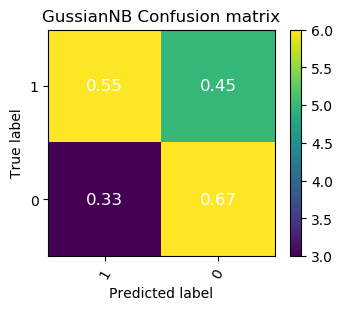

In [27]:
# Try different features, models, or both!
# What is the highest accuracy you can get?

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

X_text = data['review_text']
Y = data['positive']

X_text_a = X_text.values
X_text_a = np.append(X_text_a, new_reviews)
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_text_a)

X = tfidf_vectorizer.transform(X_text_a).toarray()

gnb = GaussianNB()
gnb.fit(X[:-20],Y)

Y_predic = gnb.predict(X[-20:])
matrix =  confusion_matrix(new_positive, Y_predic)

print("The actual positive:")
print(new_positive)
print("The predic positive:")
print(Y_predict)

labels = ['1','0']
plt.figure(figsize=(4, 3), dpi=100)
plot_confusion_matrix(matrix, labels,
                      title='GussianNB Confusion matrix')
plt.show()


The actual positive:
[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
The predic positive:
[1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0]
GussianNB Confusion matrix
[[5 6]
 [3 6]]


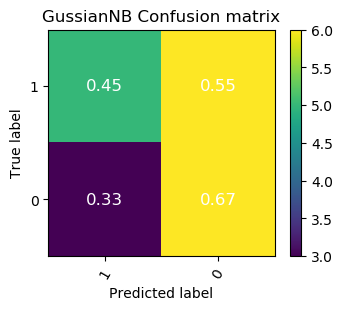

In [28]:
# Try different features, models, or both!
# What is the highest accuracy you can get?

from sklearn.naive_bayes import GaussianNB
X_text = data['review_text']
Y = data['positive']

X_text_a = X_text.values
X_text_a = np.append(X_text_a, new_reviews)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
tfidf_vectorizer.fit(X_text_a)

X = tfidf_vectorizer.transform(X_text_a).toarray()

gnb = GaussianNB()
gnb.fit(X[:-20],Y)

Y_predic = gnb.predict(X[-20:])
matrix =  confusion_matrix(new_positive, Y_predic)

print("The actual positive:")
print(new_positive)
print("The predic positive:")
print(Y_predict)

labels = ['1','0']
plt.figure(figsize=(4, 3), dpi=100)
plot_confusion_matrix(matrix, labels,title='GussianNB(change parameters) Confusion matrix')
plt.show()

In [ ]:
# Try different features, models, or both!
# What is the highest accuracy you can get?

from sklearn.svm import SVC
X_text = data['review_text']
Y = data['positive']

X_text_a = X_text.values
X_text_a = np.append(X_text_a, new_reviews)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
tfidf_vectorizer.fit(X_text_a)

X = tfidf_vectorizer.transform(X_text_a).toarray()

svc = SVC(gamma='auto')
svc.fit(X[:-20],Y)

Y_predic = svc.predict(X[-20:])
matrix =  confusion_matrix(new_positive, Y_predic)

print("The actual positive:")
print(new_positive)
print("The predic positive:")
print(Y_predict)

labels = ['1','0']
plt.figure(figsize=(4, 3), dpi=100)
plot_confusion_matrix(matrix, labels,title='SVM Confusion matrix')
plt.show()